# Library and Packages Import

In [12]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import _pickle as pkl

train_file, test_file = './data/train.csv', './data/test.csv'

# Pre-define Functions

In [13]:
def preprocessor(text):
    """
    - remove HTML tags
    - remove punctuation
    - convert to lowercase
    """
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

In [17]:
nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    """
    - tokenization
    - word-stemming
    - remove stop-word
    """
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Che\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def get_stream(path, size):
    for chunk in pd.read_csv(path, chunksize=size):
        yield chunk

txt = next(get_stream(path=train_file, size=10))['Page content'][0]

# Data Pre-processing

In [20]:
print(tokenizer_stem_nostop(preprocessor(txt)))

['clara', 'moskowitz', 'space', 'com', 'utc', 'nasa', 'grand', 'challeng', 'stop', 'asteroid', 'destroy', 'earth', 'may', 'killer', 'asteroid', 'head', 'earth', 'nasa', 'decid', 'someth', 'space', 'agenc', 'announc', 'new', 'grand', 'challeng', 'june', 'find', 'danger', 'space', 'rock', 'figur', 'stop', 'destroy', 'planet', 'new', 'mission', 'build', 'project', 'alreadi', 'underway', 'nasa', 'includ', 'plan', 'captur', 'asteroid', 'pull', 'toward', 'moon', 'send', 'astronaut', 'visit', 'part', 'grand', 'challeng', 'agenc', 'issu', 'request', 'inform', 'today', 'aim', 'solicit', 'idea', 'industri', 'academia', 'public', 'improv', 'asteroid', 'mission', 'plan', 'ask', 'think', 'concept', 'differ', 'approach', 'describ', 'william', 'gerstenmai', 'nasa', 'associ', 'administr', 'human', 'explor', 'oper', 'said', 'yesterday', 'nasa', 'event', 'announc', 'initi', 'want', 'think', 'way', 'enhanc', 'get', 'see', 'also', 'work', 'nasa', 'asteroid', 'capturerespons', 'request', 'inform', 'also', 

# Model

In [18]:
hashvec = HashingVectorizer(n_features=2**20, 
                            preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop)
# loss='log' gives logistic regression
clf = SGDClassifier(loss='log', max_iter=100, tol=1e-3)
batch_size = 1000
stream = get_stream(path=train_file, size=batch_size)
classes = np.array([-1, 1])
train_auc, val_auc = [], []

# we use one batch for training and another for validation in each iteration
iters = (26000 + batch_size - 1) // (batch_size * 2)
for i in range(iters):
    batch = next(stream)
    X_train, y_train = batch['Page content'], batch['Popularity']
    if X_train is None:
        break
    X_train = hashvec.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    train_auc.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    
    # validate
    batch = next(stream)
    X_val, y_val = batch['Page content'], batch['Popularity']
    score = roc_auc_score(y_val, clf.predict_proba(hashvec.transform(X_val))[:,1])
    val_auc.append(score)
    print(f'[iter:{i:2d}] score: {score:.4f}')

[iter: 0] score: 0.4925
[iter: 1] score: 0.5533
[iter: 2] score: 0.5170
[iter: 3] score: 0.5248
[iter: 4] score: 0.5416
[iter: 5] score: 0.4926
[iter: 6] score: 0.5372
[iter: 7] score: 0.5373
[iter: 8] score: 0.5163
[iter: 9] score: 0.5009
[iter:10] score: 0.5490
[iter:11] score: 0.5605
[iter:12] score: 0.5230


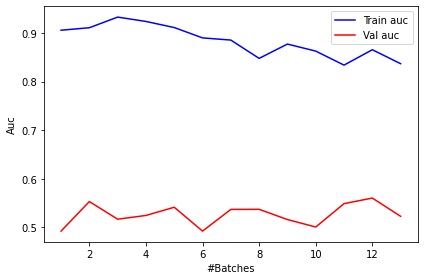

In [19]:
# Plot training curve

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.show()